<a href="https://colab.research.google.com/github/alan-w25/Cancer-Capstone/blob/main/delfi/delfi_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We will begin to test many models to predict the days alive variable. Procedure we will follow:
1. Choose a model
1. Choose Objective function
1. Choose learning algorithm
1. Add in regularization, adjust hyperparameters, etc

First we will just test the models with all the features, and do some feature selection if need be for statistical methods. It seems that for clinical relevance, we should indeed keep all the samples and should not drop any features of interest

This document will comprise of all the testing of learning models for the delfi_score data. We are aiming to predict the days_alive variable with the survival_status as our event occured indicator. There are several ML methods in literature that have good results and we will use those and other methods to obtain the best results with our data. <br>

Before applying any models, there are two considerations that we can make to transform our data. First, we can uncensor the data, if the number of censored samples is not too great. This method could cause bias in terms of traditional methods <br>

The models that we will be testing have several categories:
1. Linear Models
1. Tree Ensemble Methods
1. Neural Networks
1. Deep Methods



The following procedure will be what we will follow to determine the 'time to death', or the 'days_alive' variable. We will use the models to model the ISDs (individual survival distribution) of the samples and then from there we will use the median time as the survival time. K-fold cross validation will be used to validate the models

We will also use two types of metrics to evaluate the models that we develop: the C-index (concordance index) of the predictions on the test set and also the MAE (Mean Absolute Error on the test set)

Want to use the kaplan-meier curve and the evaluation of those metrics to act as our baseline

In [1]:
!pip install scikit-survival

Defaulting to user installation because normal site-packages is not writeable


# Setting up the data

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from Evaluator import ScikitSurvivalEvaluator



/common/home/alw228/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
data = pd.read_csv('data_Lucas_encoded.csv', index_col=[0])
data.head()

,survival_status,days_alive,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
0,1,1059,0.099037,1,0,0,0,0,0,0,1,0
1,1,1640,0.533453,1,0,0,0,0,0,0,1,0
2,1,101,0.822662,0,0,0,1,0,0,1,0,0
3,1,1228,0.238950,0,0,0,1,0,0,1,0,0
4,1,754,0.199820,0,0,1,0,1,0,0,0,0


In [4]:
data['survival_status'] = data['survival_status'].astype('bool')
data.head()

,survival_status,days_alive,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
0,True,1059,0.099037,1,0,0,0,0,0,0,1,0
1,True,1640,0.533453,1,0,0,0,0,0,0,1,0
2,True,101,0.822662,0,0,0,1,0,0,1,0,0
3,True,1228,0.238950,0,0,0,1,0,0,1,0,0
4,True,754,0.199820,0,0,1,0,1,0,0,0,0


In [5]:
data['survival_status'].value_counts()

survival_status
True     78
False    17
Name: count, dtype: int64

We have 17 alive and 78 dead.

In [6]:
Y = data[['survival_status', 'days_alive']]
Y = np.array(list(zip(data['survival_status'], data['days_alive'])),
             dtype = [('survival_status', 'bool'), ('days_alive', 'float')])
X = data.drop(['survival_status', 'days_alive', ], axis = 1)
print("X Matrix: ")
print(X.head())
print()

print("Y Matrix: ")
print(Y[1:5])


X Matrix: 
   delfi_score  stage_I  stage_II  stage_III  stage_IV  \
0     0.099037        1         0          0         0   
1     0.533453        1         0          0         0   
2     0.822662        0         0          0         1   
3     0.238950        0         0          0         1   
4     0.199820        0         0          1         0   

   treatment_Chemotherapy/Radiation with curative intent  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  1       

   treatment_No treatment  treatment_Palliative Chemotherapy/Radiation  \
0                       0                                            0   
1                       0                                            0   
2                       0                                

Want to split with equal distributions of censored and uncensored individuals

In [7]:
from sklearn.model_selection import train_test_split

censored_x = X[Y['survival_status'] == 0]
uncensored_x = X[Y['survival_status'] == 1]

censored_y = Y[Y['survival_status'] == 0] 
uncensored_y = Y[Y['survival_status'] == 1] 

c_train, c_test, c_y_train, c_y_test = train_test_split(censored_x, censored_y, test_size = 0.2, random_state = 42)
uc_train, uc_test, uc_y_train, uc_y_test = train_test_split(uncensored_x, uncensored_y, test_size = 0.2, random_state = 42)

X_train = pd.concat([c_train, uc_train])
X_test = pd.concat([c_test, uc_test])
y_train = np.concatenate((c_y_train, uc_y_train), axis = 0)
y_test = np.concatenate((c_y_test, uc_y_test), axis = 0)

In [8]:
X_train[:5]

,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
30,0.359992,0,0,0,1,1,0,0,0,0
68,0.999358,0,1,0,0,0,0,0,1,0
26,0.298852,0,0,1,0,1,0,0,0,0
55,0.975395,0,0,1,0,0,0,0,0,1
13,0.097588,1,0,0,0,0,0,0,1,0


In [9]:
X_test[:5]

,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
7,0.311196,1,0,0,0,0,0,0,1,0
12,0.098674,0,0,0,1,1,0,0,0,0
23,0.694009,0,1,0,0,1,0,0,0,0
73,0.992746,0,0,1,0,1,0,0,0,0
45,0.746180,0,1,0,0,0,0,1,0,0


In [10]:
y_train[0:5]

array([(False, 2722.), (False, 2575.), (False, 2771.), (False, 2724.),
       (False, 2760.)],
      dtype=[('survival_status', '?'), ('days_alive', '<f8')])

In [11]:
y_test[:5]

array([(False, 2710.), (False, 2766.), (False, 2695.), (False, 2758.),
       ( True,  184.)],
      dtype=[('survival_status', '?'), ('days_alive', '<f8')])

### Model Training Functions

In [8]:
# train model function
#Runs k-fold cross validation and outputs a list of validation losses based on the criterion specified 
#works with Cox models 
from sklearn.model_selection import StratifiedKFold
from Evaluator import ScikitSurvivalEvaluator
def cv_cox_models(model, k_folds, X, y, mae = True, weighting = True, log_scale = False, rs = 0):
    scores = []
    kf = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X, y['survival_status']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        #
        if not mae: 
            #c-index 
            #predictions = model.predict(X_test)
            cindex = model.score(X_test, y_test)
            scores.append(cindex)
        else: 
            
        
            survival_curves = model.predict_survival_function(X_test)
            eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
            mae = eval.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            scores.append(mae)
        
    return scores
        
    


In [9]:
def train_full_cox(model, X_tr, y_tr, X_t, y_t, mae = True, weighting = True, log_scale = False, rs = 0): 
    model.fit(X_tr, y_tr)
    score = None
    if not mae: 
        score = model.score(X_t, y_t)
    else:
        surv_c = model.predict_survival_function(X_t)
        eval = ScikitSurvivalEvaluator(surv_c, y_t['days_alive'], y_t['survival_status'], y_tr['days_alive'], y_tr['survival_status'], predict_time_method="Median")
        score = eval.mae(method = "Pseudo_obs", weighted = True, log_scale = False)
    return score

Before we train any models, a major question in survival analysis is what metric can we use to evaluate our models. The most popular models include:
1. C-Index (Harrell's Concordance Index ) -> Ratio of correctly ordered concordant pairs to comparable pairs. C-Index close to 1 represents perfect prediction
1. MAE (Mean Absolute Error) -> literature has introduced many adaptations of the MAE estimator to handle survival data. This means estimating the true survival time of the censored samples or other methods. This reduces the survival problem down to a typical regression/classification problem.

# Models


## Baseline Kaplan-Meier

In [10]:
from lifelines import KaplanMeierFitter
from sklearn.model_selection import KFold  
from Evaluator import LifelinesEvaluator
def train_km(model, folds, y, weighting = True, log_scale = False, rs = 0): 
    scores = [] 
    kf = StratifiedKFold(folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(y, y['survival_status']):
        y_tr, y_t = y[train_index], y[test_index]
        fitted_model = model.fit(y_tr['days_alive'], event_observed = y_tr['survival_status']).survival_function_ 
        survival_curve_df = pd.concat([fitted_model] * y_t.shape[0], axis=1)
        eval = LifelinesEvaluator(survival_curve_df, y_t['days_alive'], y_t['survival_status'], y_tr['days_alive'], y_tr['survival_status'])
        mae = eval.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
        scores.append(mae)
    return scores

In [11]:
baseline_mae_scores = train_km(KaplanMeierFitter(), 10, y_train)
print(f"Average Baseline MAE: {np.mean(baseline_mae_scores)}")


Average Baseline MAE: 769.7045489200542


Now test on the test set of the data:

In [16]:
kmf = KaplanMeierFitter()
survival_curve_baseline = kmf.fit(y_train['days_alive'], event_observed=y_train['survival_status']).survival_function_
survival_curve_base = pd.concat([survival_curve_baseline] * y_test.shape[0], axis=1)
eval = LifelinesEvaluator(survival_curve_base, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
mae = eval.mae(method = "Pseudo_obs", weighted = True, log_scale = False)
print(f"MAE for Test Set: {mae}")
print(f"C-Index for the Test Set: {0.5}")


MAE for Test Set: 774.5856353591108
C-Index for the Test Set: 0.5


We will treat this MAE as the baseline for all our models and also this c-index of 0.5, indicative of 0 predictive power as our baseline. 

## Linear Models

There is one main linear models that we can use for survival analysis that applies to our distribution of the time to event variable: 
- Cox PH Model 
- Accelerated Failure Time (AFT)

Cox PH is semi-parametric and outputs the hazard function <br>
AFT assumes a distribution of the time to event variable

### Ridge Cox PH - Finding the Best Regularization Penalty

Let's test better versions of the Cox model: perhaps a regularized model to regularize the features that we determined were not valuable in the exploration process. Use cv to search for the best alpha value for regularization

In [20]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
def find_best_alpha_cph(alpha_vals, k_folds, X, y, weighting = True, log_scale = False, rs = 0): 

    kf = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = rs)
    scores = []
    best_alpha = None
    min_avg_mae = float('inf')
    
    for a in alpha_vals:
        mae_scores = []
        model = CoxPHSurvivalAnalysis(alpha = a, n_iter = 10000)
        for train_index, test_index in kf.split(X, y['survival_status']):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict_survival_function(X_test)
            
            eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
            mae = eval.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            mae_scores.append(mae)
            
        avg_score = np.mean(mae_scores)
        scores.append(avg_score)

        if avg_score < min_avg_mae:
            min_avg_mae = avg_score
            best_alpha = a

    return best_alpha, min_avg_mae, scores


In [21]:
alpha_vals = 10**np.linspace(-5, 5, 50)
best_initial_alpha, min_avg_mae_init, avg_maes_init = find_best_alpha_cph(alpha_vals, 10, X_train, y_train)
print(f"Best Alpha Value: {best_initial_alpha}")
print(f"Minimum average mae of best alpha: {min_avg_mae_init}")

Best Alpha Value: 5.1794746792312125
Minimum average mae of best alpha: 557.2128428394824


We can also use gridsearch to find the best alpha based on concordance index: 

In [ ]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
gcv_cph_ridge = GridSearchCV(CoxPHSurvivalAnalysis(n_iter = 10000), param_grid = {"alpha":alpha_vals}, error_score = 0.5, cv = kf).fit(X_train,y_train)
print(f"Best Alpha Value from GridSearchCV: {gcv_cph_ridge.best_params_}")

Best Alpha Value from GridSearchCV: {'alpha': 5.1794746792312125}


In [ ]:
cph_ridge_init = CoxPHSurvivalAnalysis(alpha = best_initial_alpha, n_iter = 10000)
cph_ridge_init_gcv = CoxPHSurvivalAnalysis(n_iter = 10000).set_params(**gcv_cph_ridge.best_params_)
mae_cph_ridge= cv_cox_models(cph_ridge_init, 10, X_train, y_train)
c_cph_ridge = cv_cox_models(cph_ridge_init_gcv, 10, X_train, y_train, mae = False)

print(f"Average mae from optimized Ridge Cox model: {np.mean(mae_cph_ridge)}")
print(f"Average mae from optimized Ridge Cox model: {np.mean(c_cph_ridge)}")


Average mae from optimized Ridge Cox model: 557.2128428394824
Average mae from optimized Ridge Cox model: 0.8134920634920635


In [ ]:
mae_init_cph_ridge = train_full_cox(cph_ridge_init, X_train, y_train, X_test, y_test)
c_init_cph_ridge = train_full_cox(cph_ridge_init_gcv, X_train, y_train, X_test, y_test, mae = False)
print(f"Final Test MAE for Ridge Cox: {mae_init_cph_ridge}")
print(f"Final Test C-Index for Ridge Cox: {c_init_cph_ridge}")

Final Test MAE for Ridge Cox: 649.7771112419935
Final Test C-Index for Ridge Cox: 0.8070652173913043


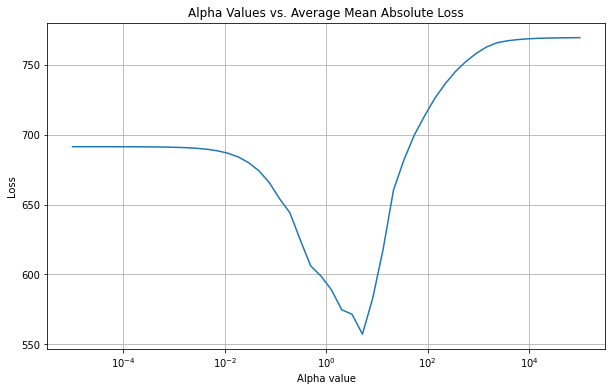

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Alpha Values vs. Average Mean Absolute Loss")
plt.plot(alpha_vals, avg_maes_init)
plt.xlabel("Alpha value")
plt.xscale("log")
plt.ylabel("Loss")
plt.grid()
plt.show()

The performance of the ridge regularization seems to be better than the baseline model by a significant amount. The C-index already is very high around 0.8. 

### LASSO Cox

In sksurv, the LASSO penalty can be applied through the Cox Elastic Net model, which leverages elastic net penalization. Our goal is to see if pure LASSO regularization can perform better than the ridge regularization that we tested above. Eventually, we want to choose a good ratio between the L1:L2 regularization terms to hopefully get a more accurate model.

In [ ]:
#use cv to find average loss values
from sksurv.linear_model import CoxnetSurvivalAnalysis
cox_lasso_init = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio = 0.01, fit_baseline_model= True)
cox_c_lasso_init = CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.01, fit_baseline_model = True)
avg_lasso_mae = cv_cox_models(cox_lasso_init, 10, X_train, y_train)
avg_lasso_c = cv_cox_models(cox_c_lasso_init, 10, X_train, y_train, False)
print(f"Average LASSO MAE: {np.mean(avg_lasso_mae)}")
print(f"Average LASSO C-Index: {np.mean(avg_lasso_c)}")

Average LASSO MAE: 650.9235384333134
Average LASSO C-Index: 0.8256613756613757


In [ ]:
mae_final_init_lasso = train_full_cox(cox_lasso_init, X_train, y_train, X_test, y_test)
c_final_init_lasso = train_full_cox(cox_c_lasso_init, X_train, y_train, X_test, y_test, False)
print(f"Initial LASSO Model MAE: {mae_final_init_lasso}")
print(f"Initial LASSO Model C-Index: {c_final_init_lasso}")

Initial LASSO Model MAE: 749.4748692827623
Initial LASSO Model C-Index: 0.8125


In [ ]:
alpha_scores = cox_lasso_init.alphas_

In [ ]:
print("Possible alpha values: ")
print(alpha_scores)

Possible alpha values: 
[0.2589278  0.24715913 0.23592537 0.22520219 0.21496641 0.20519585
 0.19586938 0.18696682 0.17846889 0.1703572  0.1626142  0.15522314
 0.14816801 0.14143354 0.13500517 0.12886897 0.12301168 0.11742061
 0.11208366 0.10698929 0.10212646 0.09748465 0.09305383 0.08882439
 0.08478718 0.08093347 0.07725492 0.07374357 0.07039181 0.06719239
 0.06413839 0.0612232  0.05844051 0.0557843  0.05324882 0.05082858
 0.04851834 0.04631311 0.04420811 0.04219878 0.04028078 0.03844996
 0.03670235 0.03503417 0.03344181 0.03192183 0.03047093 0.02908598
 0.02776398 0.02650206 0.0252975  0.02414769 0.02305014 0.02200248
 0.02100243 0.02004784 0.01913663 0.01826684 0.01743659 0.01664407
 0.01588757 0.01516545 0.01447616 0.0138182  0.01319014 0.01259063
 0.01201836 0.01147211 0.01095069 0.01045296 0.00997786 0.00952435
 0.00909145 0.00867823 0.00828379 0.00790728 0.00754788 0.00720482
 0.00687735 0.00656476 0.00626638 0.00598157 0.0057097  0.00545018
 0.00520246 0.004966   0.00474029 0.00

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
coxlasso = CoxnetSurvivalAnalysis(l1_ratio = 1.0, fit_baseline_model= True)
cv = KFold(n_splits=10, shuffle=True, random_state=0)
param_grid = [[v] for v in alpha_scores]
grid_search = GridSearchCV(
    estimator = coxlasso,
    error_score = 0.5,
    param_grid = {"alphas":param_grid}, 
    cv = cv).fit(X_train,y_train)

/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, 

In [ ]:
print(grid_search.best_params_)

{'alphas': [0.06122320349266912]}


In [ ]:
best_lasso_model = CoxnetSurvivalAnalysis(l1_ratio = 1.0, fit_baseline_model=True)
best_lasso_model.set_params(**grid_search.best_params_)
avg_lasso_mae = cv_cox_models(best_lasso_model, 10, X_train, y_train)
avg_lasso_c = cv_cox_models(best_lasso_model, 10, X_train, y_train, False)

print(f"Best Lasso Model CV MAE: {np.mean(avg_lasso_mae)}")
print(f"Best Lasso Model CV C-Index: {np.mean(avg_lasso_c)}")

Best Lasso Model CV MAE: 617.2695761004409
Best Lasso Model CV C-Index: 0.8134920634920635


In [ ]:
full_mae_lasso = train_full_cox(best_lasso_model, X_train, y_train, X_test, y_test)
full_c_lasso = train_full_cox(best_lasso_model, X_train, y_train, X_test, y_test, False)
print(f"Final LASSO MAE on Full Train and Test Set: {full_mae_lasso}")
print(f"Final LASSO MAE on Full Train and Test Set: {full_c_lasso}")

Final LASSO MAE on Full Train and Test Set: 636.0816911640188
Final LASSO MAE on Full Train and Test Set: 0.779891304347826


This value with just Lasso regression seems to be higher than that of just ridge regression. However, the validation MAE is higher. This model generalizes better. Next, we will use cv to test the ElasticNet and find the optimal balance between L1 and L2 regularization. Based on the C-index, performance is just about the same as strictly ridge regularization

### ElasticNet Cox Ph - Finding the best L1:L2 Ratio

In [ ]:
l1_ratios = np.linspace(0.01,.99,50)
coxnet = CoxnetSurvivalAnalysis(fit_baseline_model=True)
gcv = GridSearchCV(
    estimator = coxnet,
    error_score = 0.5,
    param_grid = {"alphas":param_grid, 
                  "l1_ratio":l1_ratios}, 
    cv = cv)
gcvmodel = gcv.fit(X_train,y_train)

print("Best Params: ")
print(gcv.best_params_)

/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, 

Best Params: 
{'alphas': [0.06122320349266912], 'l1_ratio': 0.99}


In [ ]:
best_elasticnet_cox = CoxnetSurvivalAnalysis(fit_baseline_model = True)
best_elasticnet_cox.set_params(**gcv.best_params_)
print(best_elasticnet_cox)

avg_mae_elasticnet = cv_cox_models(best_lasso_model, 5, X_train, y_train)
avg_c_elasticnet = cv_cox_models(best_lasso_model, 5, X_train, y_train, False)
print(f"Average Validation MAE with Elasticnet: {np.mean(avg_mae_elasticnet)}")
print(f"Average Validation C-Index with Elasticnet: {np.mean(avg_c_elasticnet)}")


CoxnetSurvivalAnalysis(alphas=[0.06122320349266912], fit_baseline_model=True,
                       l1_ratio=0.99)
Average Validation MAE with Elasticnet: 611.2121170386863
Average Validation C-Index with Elasticnet: 0.8074095022624433


In [ ]:
final_elasticnet_mae = train_full_cox(best_elasticnet_cox, X_train, y_train, X_test, y_test)
final_elasticnet_c = train_full_cox(best_elasticnet_cox, X_train, y_train, X_test, y_test, False)
print(f"Final MAE of ElasticNet Regularized Cox PH Model: {final_elasticnet_mae}")
print(f"Final MAE of ElasticNet Regularized Cox PH Model: {final_elasticnet_c}")

Final MAE of ElasticNet Regularized Cox PH Model: 636.723017170827
Final MAE of ElasticNet Regularized Cox PH Model: 0.779891304347826


Overall, the different cox models yielded ok results, with the test log MAE landing around 800, which performed better than the baseline kaplan meier model.

Another linear model that we can fit is the Accelerated Failure Time Model. It assumes 

### Accelerated Failure Time Model

In [ ]:
def calculate_mae(y_true, y_pred, log_transform=False):
    if log_transform:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)

    absolute_errors = np.abs(y_true - y_pred)
    mae = np.mean(absolute_errors)
    return mae

In [ ]:
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import StratifiedKFold
def cv_model_aft(model, k_folds, X, y, mae = True, weighting = True, log_scale = False, rs = 0): 
    scores = []
    kf = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X, y['survival_status']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        survival_curves = model.predict(X_test)
        
        if not mae: 
            cindex= concordance_index_censored(y_test['survival_status'], y_test['days_alive'], -survival_curves)
            scores.append(cindex[0])
            
        else: 
            calculate_mae(survival_curves, y_test['days_alive'])
            mae = eval.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            scores.append(mae)
        
    return scores

In [ ]:
from sksurv.linear_model import IPCRidge
initial_aft = IPCRidge()
init_aft_maes = cv_model_aft(initial_aft, 10, X_train, y_train)
init_aft_c = cv_model_aft(initial_aft, 10, X_train, y_train, False)
print(f"Average Validation MAE for AFT: {np.mean(init_aft_maes)}")
print(f"Average Validation C-Index for AFT: {np.mean(init_aft_c)}")

Average Validation MAE for AFT: 774.5856353591108
Average Validation C-Index for AFT: 0.802910052910053


In [ ]:
initial_aft.fit(X_train,y_train)
predictions = initial_aft.predict(X_test)
concordance = concordance_index_censored(y_test['survival_status'], y_test['days_alive'], -predictions)
print(f"Final Test MAE for AFT Model: {calculate_mae(predictions, y_test['days_alive'])}")
print(f"Final Test C-Index for AFT Model: {concordance[0]}")

Final Test MAE for AFT Model: 555.5627879745491
Final Test C-Index for AFT Model: 0.8070652173913043


## SVM

The procedure for SVM will be the same as for the Cox Proportional Hazards Model. We will train a model then utilize GridSearchCV with MAE scoring to evaluate the models found. Let's use the regression setting on sksurv's SVM model (which predicts the event time of the input) and then calculate our own log mae from the predictions. We will take log(predictions) - log(ground truth)

In [ ]:
from sksurv.svm import FastSurvivalSVM
def train_svm(model, X_tr, X_t, y_tr, y_t, mae = True, log_transform = False, rs = 0): 
    model.fit(X_tr, y_tr)
    score = None
    predictions = model.predict(X_t)
    if mae: 
        score = calculate_mae(y_t['days_alive'], predictions, log_transform = log_transform)
    else: 
        score = concordance_index_censored(y_t['survival_status'], y_t['days_alive'], -predictions)
    return score if mae else score[0]

In [ ]:
def cv_svm(model, X, y, k_folds, mae = True, rs = 0): 
    scores = []
    kf = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X, y['survival_status']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        survival_curves = model.predict(X_test)
        
        if mae: 
            eval = calculate_mae(y_test['days_alive'], survival_curves)
            scores.append(eval)
        else: 
            score = concordance_index_censored(y_test['survival_status'], y_test['days_alive'], -survival_curves)
            scores.append(score[0])
    return scores

### Without Kernel

The baseline survival svm does not take a kernel function as input we use cv to test the average performance and then use gridsearch cv to find the best model. 

Lets see the baseline cv and average validation scores: 

In [ ]:
from sksurv.svm import FastSurvivalSVM

svm_model = FastSurvivalSVM(max_iter = 10000, tol = 1e-5, random_state = 0, rank_ratio = 0.0, fit_intercept = True)

svm_mae_baseline = cv_svm(svm_model, X_train, y_train, 10)
svm_c_baseline = cv_svm(svm_model, X_train, y_train, 10, False)

print(f"Average Validation MAE of Linear Survival SVM: {np.mean(svm_mae_baseline)}")
print(f"Average Validation C-Index of Linear Survival SVM: {np.mean(svm_c_baseline)}")


Average Validation MAE of Linear Survival SVM: 483.82798181732807
Average Validation C-Index of Linear Survival SVM: 0.8314814814814815


In [ ]:
svm_test_mae = train_svm(svm_model, X_train, X_test, y_train, y_test)
svm_test_c = train_svm(svm_model, X_train, X_test, y_train, y_test, False)

print(f"Initial Linear Survival SVM Test MAE: {svm_test_mae}")
print(f"Initial Linear Survival SVM Test C-Index: {svm_test_c}")


Initial Linear Survival SVM Test MAE: 569.685921574561
Initial Linear Survival SVM Test C-Index: 0.8125


In [ ]:
def calculate_mse(model, X, y_pred):
     predictions = model.predict(X)
     mse = -np.mean((predictions - y_pred['days_alive']) ** 2)
     return mse

In [ ]:
#Custom scorer for gcv
from sklearn.metrics import make_scorer
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}
def custom_mae_score(model, X, y): 
    predictions = model.predict(X)
    
    '''
    cindex = concordance_index_censored(
    y["survival_status"],
    y["days_alive"],
    -predictions)
    

    return cindex[0]'''
    
    return -(calculate_mae(y['days_alive'], predictions))
    

In [ ]:
def custom_c_scorer(estimator, X, y): 
    predictions = estimator.predict(X)
    cindex = concordance_index_censored(y['survival_status'], y['days_alive'], -predictions)
    return cindex[0]

In [ ]:
from sksurv.svm import FastSurvivalSVM
param_grid = {"alpha": np.linspace(1.01, 10, 50)}
estimator = FastSurvivalSVM(max_iter = 50000, tol = 1e-4, rank_ratio = 0.0, fit_intercept = True)
gcv = GridSearchCV(
    estimator = estimator, 
    param_grid = param_grid, 
    cv = 10, 
    scoring = calculate_mse
).fit(X_train, y_train)

/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)


/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily 

In [ ]:
#gcv for best c-index 
gcv_c_svm = GridSearchCV(
    estimator = estimator, 
    param_grid = param_grid, 
    cv = 5, 
    scoring = custom_c_scorer
).fit(X_train, y_train)

/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily 

In [ ]:
print(f"Best Parameters for MAE Scorer: {gcv.best_params_}")
print(f"Best Parameters for C-Index Scorer: {gcv_c_svm.best_params_}")

Best Parameters for MAE Scorer: {'alpha': 1.9273469387755102}
Best Parameters for C-Index Scorer: {'alpha': 3.2116326530612245}


In [ ]:
svm_gcv = FastSurvivalSVM(max_iter = 10000, tol = 1e-5, random_state = 0, rank_ratio = 0.0, fit_intercept = True).set_params(**gcv.best_params_)
svm_gcv_c = FastSurvivalSVM(max_iter = 10000, tol = 1e-5, random_state = 0, rank_ratio = 0.0, fit_intercept = True).set_params(**gcv_c_svm.best_params_)
svm_gcv_mae_val = cv_svm(svm_gcv, X_train, y_train, 10)
svm_gcv_c_val = cv_svm(svm_gcv_c, X_train, y_train, 10, False)

print(f"Average Validation Scores of Linear Survival SVM: {np.mean(svm_gcv_mae_val)}")
print(f"Average Validation C-Index of Linear Survival SVM: {np.mean(svm_gcv_c_val)} ")

Average Validation Scores of Linear Survival SVM: 480.51155532133225
Average Validation C-Index of Linear Survival SVM: 0.8124338624338625 


In [ ]:
svm_gcv_test_mae = train_svm(svm_gcv, X_train, X_test, y_train, y_test)
svm_gcv_test_c = train_svm(svm_gcv_c, X_train, X_test, y_train, y_test, False)

print(f"Linear Survival SVM After Grid Search Test MAE: {svm_gcv_test_score}")
print(f"Linear Survival SVM After Grid Search Test C-Index: {svm_gcv_test_c}")

Linear Survival SVM After Grid Search Test MAE: 581.6365124025184
Linear Survival SVM After Grid Search Test C-Index: 0.8070652173913043


It seems that the linear svm performs relatively well. The mae are much better than the previous linear models we tested. However the C-index seems to be hovering around the same 0.8 that we've been seeing. No significant increases there. Perhaps fitting a kernel-based svm will yield us better results

### Kernel-Based SVM

In [ ]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

kernel_matrix = clinical_kernel(X_train)
kssvm = FastKernelSurvivalSVM(rank_ratio = 0.0, fit_intercept = True, kernel = "precomputed", max_iter = 10000)

kgcv = gcv_c_svm = GridSearchCV(estimator = kssvm, param_grid = param_grid, cv = 10, scoring = custom_mae_score)
kgcv = kgcv.fit(kernel_matrix, y_train)

/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/common/home/alw228/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily 

In [ ]:
print(f"Best Params for Clinical Kernel: {kgcv.best_params_}")

Best Params for Clinical Kernel: {'alpha': 7.247959183673469}


It seems that many of these models are not converging, so we're going to test out the different kernels and alpha values with typical k-fold cv

In [ ]:
svm_ck_kgcv = FastKernelSurvivalSVM(max_iter = 50000, rank_ratio = 0.0, fit_intercept = True).set_params(**kgcv.best_params_)
svm_kgcv_mae_val = cv_svm(svm_ck_kgcv, X_train, y_train, 10)
print(f"Linear Survival SVM After Grid Search Test MAE: {np.mean(svm_kgcv_mae_val)}")


/tmp/ipykernel_933227/404000094.py:8: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)


Linear Survival SVM After Grid Search Test MAE: 480.53495851789955


Want to test combination of kernel and the alpha. So we will run gcv on the kernel and also the alpha value

In [ ]:
def find_best_kernel(kernels, k_folds, X, y, mae = True, log_scale = False, rs = 0):
    scores = []
    kf = StratifiedKFold(k_folds, shuffle = True, random_state= rs)
    best_kernel = None
    min_avg_mae = float('inf')
    
    for kernel in kernels:
        
        model = FastKernelSurvivalSVM(rank_ratio = 0.0, kernel = kernel, fit_intercept = True, max_iter = 10000)
        mae_scores = []
        
        
        for train_index, test_index in kf.split(X, y['survival_status']): 
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict(X_test)
            score = calculate_mae(survival_curves, y_test['days_alive'])
            mae_scores.append(score)
            
            
        avg_score = np.mean(mae_scores)
        scores.append(avg_score)

        if avg_score < min_avg_mae:
            min_avg_mae = avg_score
            best_kernel = kernel
        
    return best_kernel, min_avg_mae, scores
            

   

In [ ]:
def find_alpha_svm(alphas, k_folds, X, y, mae = True, log_scale = False, rs = 0):
    scores = []
    kf = StratifiedKFold(k_folds, shuffle = True, random_state= rs)
    best_alpha = None
    threshold = float('inf') if mae else -float('inf')
    
    for alpha in alphas:
        
        model = FastKernelSurvivalSVM(rank_ratio = 0.0, kernel = 'poly', fit_intercept = True, max_iter = 10000, alpha = alpha)
        avg_scores = []
        
        
        for train_index, test_index in kf.split(X, y['survival_status']): 
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict(X_test)
            
            if not mae: 
                cindex = concordance_index_censored(y_test['survival_status'], y_test['days_alive'], -survival_curves)
                score = cindex[0]
                avg_scores.append(score)
            else:
                score = calculate_mae(survival_curves, y_test['days_alive'])
                avg_scores.append(score)
            
            
        avg_score = np.mean(avg_scores)
        scores.append(avg_score)

        if not mae: 
            if avg_score > threshold: 
                best_alpha = alpha
                threshold = avg_score
        else: 
            if avg_score < threshold: 
                best_alpha = alpha 
                threshold = avg_score
        
    return best_alpha, threshold, scores

In [ ]:
kernels = ['sigmoid', 'poly', 'rbf']
best_kernel, _,  _ = find_best_kernel(kernels, 10, X_train, y_train)

/tmp/ipykernel_933227/4004672139.py:18: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train)
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/svm/survival_svm.py:1226: RuntimeWarning: overflow encountered in exp
  val = np.exp(val)
/tmp/ipykernel_933227/4004672139.py:18: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train)
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/svm/survival_svm.py:1226: RuntimeWarning: overflow encountered in exp
  val = np.exp(val)
/tmp/ipykernel_933227/4004672139.py:18: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/4004672139.py:18: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(

In [ ]:
print("Best Kernel: "  + best_kernel)

Best Kernel: poly


In [ ]:
best_alpha_svm_mae,_,_ = find_alpha_svm(np.linspace(1.01, 10, 50), 10, X_train, y_train)

/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: 

In [ ]:
print(f"Best Alpha: {best_alpha_svm_mae}")

Best Alpha: 9.816530612244899


In [ ]:
best_alpha_svm_c,_,_ = find_alpha_svm(np.linspace(1.01, 10, 50), 10, X_train, y_train, False)

/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  model.fit(X_train, y_train)
/tmp/ipykernel_933227/1769868839.py:18: 

In [ ]:
print(f"Best Alpha for C-Index: {best_alpha_svm_c}")

Best Alpha for C-Index: 1.01


In [ ]:
kssvmk_m = FastKernelSurvivalSVM(rank_ratio = 0.0, fit_intercept = True, max_iter = 10000, kernel = 'poly', alpha = best_alpha_svm_mae)
kssvmk_c = FastKernelSurvivalSVM(rank_ratio = 0.0, fit_intercept = True, max_iter = 10000, kernel = 'poly', alpha = best_alpha_svm_c)
svm_poly_mae_val = cv_svm(kssvmk_m, X_train, y_train, 10)
svm_poly_c_val = cv_svm(kssvmk_c, X_train, y_train, 10, False)
print(f"Validation Average MAE of Poly Kernel: {np.mean(svm_poly_mae_val)}")
print(f"Validation Average C-Index of Poly Kernel: {np.mean(svm_poly_c_val)}")



Validation Average MAE of Poly Kernel: 471.1587049234844
Validation Average C-Index of Poly Kernel: 0.8171957671957673


In [19]:
final_kernel_mae = train_svm(kssvmk_m, X_train, X_test, y_train, y_test)
final_kernel_c = train_svm(kssvmk_c, X_train, X_test, y_train, y_test, False)
print(f"Final Test Loss for SVM MAE: {final_kernel_mae}")
print(f"Final Test Loss for SVM C-Index: {final_kernel_c}")

NameError: name 'train_svm' is not defined

## Random Survival Forest

Random survival forests are one of the most popular methods for estimating the time to event variable. We want to be careful of overfitting the model because of small sample size. Therefore, we want to perform cv on to figure out a good value for the different hyperparameter values.

In [12]:
def cv_rsf(model, X, y, k_folds, mae = True, weighting = True, log_scale = False, rs = 0):
    scores = []
    kf = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X, y['survival_status']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        survival_curves = model.predict_survival_function(X_test)
        
        if mae: 
            eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
            mae = eval.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            scores.append(mae)
        else: 
            score = model.score(X_test, y_test)
            scores.append(score)
    return scores

Lets check out how the base model fits the data, with default parameters

In [67]:
from sksurv.ensemble import RandomSurvivalForest
init_rsf = RandomSurvivalForest(random_state = 0)
initial_rsf_mae = cv_rsf(init_rsf, X_train, y_train, 10)
initial_rsf_c = cv_rsf(init_rsf, X_train, y_train, 10, False)

print(f"Initial RSF Validation MAE: {np.mean(initial_rsf_mae)}")
print(f"Initial RSF Validation C-Index: {np.mean(initial_rsf_c)}")


Initial RSF Validation MAE: 613.932116135555
Initial RSF Validation C-Index: 0.8035714285714285


The initial performance of the rsf seems to not out perform previous methods of estimation. This could very much well be due to non-tuned hyper parameters num_estimators, min_samples_split (minimum samples to mark a split), min_samples_leaf (minimum samples for leaf node to be determined)

In [41]:
def find_best_estimators(estimator_vals, X, y, k_folds, random_states, weighting = True, log_scale = False): 
    
    scores_per_estimator = {val: [] for val in estimator_vals}
    
    best_estimator_size = None
    min_avg_mae = float('inf')
    
    for rs in random_states:
        
        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=rs)

        
        for val in estimator_vals:
            
            model = RandomSurvivalForest(n_estimators = val, random_state= rs)
            mae_scores = []
            
            for train_index, test_index in kf.split(X, y['survival_status']): 
                
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                model.fit(X_train, y_train)
                
                survival_curves = model.predict_survival_function(X_test)
                scorer = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
                score = scorer.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
                mae_scores.append(score)
                
                
            avg_score = np.mean(mae_scores)
            scores_per_estimator[val].append(avg_score)

    final_scores = {val: np.mean(scores) for val, scores in scores_per_estimator.items()}
    best_estimator_size = min(final_scores, key=final_scores.get)
    min_avg_mae = final_scores[best_estimator_size]

        
    return best_estimator_size, min_avg_mae, final_scores

In [43]:
e_vals = np.arange(100,1001, 100)
random_states = [42,64,128]

best_e, min_avg, all_losses = find_best_estimators(e_vals, X_train, y_train, 10, random_states)
print(f"The Best Number of Trees in Ensemble to Use: {best_e}")
print(f"This best estimator size had the lowest mae of: {min_avg}")

The Best Number of Trees in Ensemble to Use: 100
This best estimator size had the lowest mae of: 603.0751132749159


Text(0.5, 0, 'Number of Estimators')

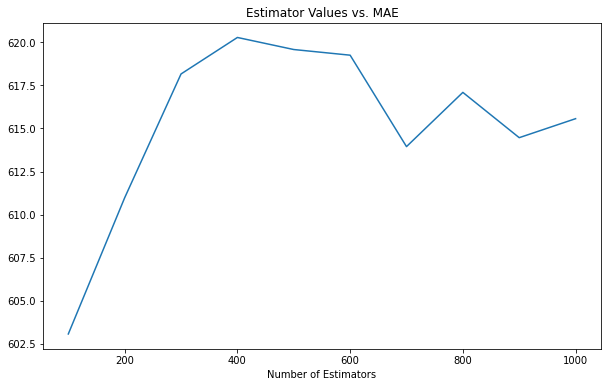

In [45]:
#plot the values vs the losses
estimators = list(all_losses.keys())
vals = list(all_losses.values())

plt.figure(figsize = (10,6))
plt.title("Estimator Values vs. MAE")
plt.plot(estimators, vals)
plt.xlabel("Number of Estimators")

Found best number of trees to use is 100 trees. 

In [52]:
def find_best_depth(depth_vals, X, y, k_folds, weighting = True, log_scale = False, rs = 0): 
    scores = []
    best_estimator_size = None
    min_avg_mae = float('inf')        
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=rs)

    
    for val in depth_vals:
        model = RandomSurvivalForest(n_estimators = 100, max_depth = val)
        mae_scores = []
        
        for train_index, test_index in kf.split(X, y['survival_status']): 
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict_survival_function(X_test)
            scorer = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
            score = scorer.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            mae_scores.append(score)
            
            
        avg_score = np.mean(mae_scores)
        scores.append(avg_score)

        if avg_score < min_avg_mae: 
            best_estimator_size = val
            min_avg_mae = avg_score

        
    return best_estimator_size, min_avg_mae, scores

In [54]:
d_vals = [2,3,4,5,6]
best_depth, min_avg_depth_mae, depth_scores = find_best_depth(d_vals, X_train, y_train, 10)


print(f"The Best Number of Trees in Ensemble to Use: {best_depth}")
print(f"This best estimator size had the lowest mae of: {min_avg_depth_mae}")


The Best Number of Trees in Ensemble to Use: 2
This best estimator size had the lowest mae of: 579.0654823125363


In [58]:
def find_best_min_sample_split(split_vals, X, y, k_folds, weighting = True, log_scale = False, rs = 0): 
    scores = []
    best_estimator_size = None
    min_avg_mae = float('inf')        
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=rs)

    
    for val in split_vals:
        model = RandomSurvivalForesst(n_estimators = 100, max_depth = 2, min_samples_split = val, random_state = rs)
        mae_scores = []
        
        for train_index, test_index in kf.split(X, y['survival_status']): 
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict_survival_function(X_test)
            scorer = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
            score = scorer.mae(method = "Pseudo_obs", weighted = weighting, log_scale = log_scale)
            mae_scores.append(score)
            
            
        avg_score = np.mean(mae_scores)
        scores.append(avg_score)

        if avg_score < min_avg_mae: 
            best_estimator_size = val
            min_avg_mae = avg_score

        
    return best_estimator_size, min_avg_mae, scores

In [59]:
mss_vals = [6,7,8,9,10]
best_mss, min_avg_mss, mss_scores = find_best_depth(mss_vals, X_train, y_train, 10)


print(f"The Best Number of samples to split in Ensemble to Use: {best_mss}")
print(f"This best estimator size had the lowest mae of: {min_avg_mss}")


The Best Number of samples to split in Ensemble to Use: 10
This best estimator size had the lowest mae of: 604.4550709776024


In [75]:
#Cross-validate the best model
best_rsf = RandomSurvivalForest(n_estimators = 100, max_depth = 2, min_samples_split = 10, min_samples_leaf = 4, random_state = 0)

final_rsf_mae = cv_rsf(best_rsf, X_train, y_train, 10)
final_rsf_c = cv_rsf(best_rsf, X_train, y_train, 10, False)

print(f"RSF Validation MAE: {np.mean(final_rsf_mae)}")
print(f"RSF Validation C-Index: {np.mean(final_rsf_c)}")


RSF Validation MAE: 592.3137088728471
RSF Validation C-Index: 0.8191137566137566


The best model seems to perform better than original model by significant margin in terms of mae, but not that significant vs the C-index.

In [77]:
# on the test set 
best_rsf.fit(X_train, y_train)

scorer = ScikitSurvivalEvaluator(best_rsf.predict_survival_function(X_test), y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
score = scorer.mae(method = "Pseudo_obs", weighted = True, log_scale = False)

print(f"The final test mae of the rsf model: {score}")
print(f"The final test c-index of the rsf model: {best_rsf.score(X_test, y_test)}")

The final test mae of the rsf model: 575.136435035977
The final test c-index of the rsf model: 0.7989130434782609
